In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import json
import fsspec
import pickle
import os
from scipy.stats import norm
import seaborn as sns

#from pyqg_parameterization_benchmarks.neural_networks import FCNNParameterization
#from pyqg_parameterization_benchmarks.utils import energy_budget_figure
#from pyqg_parameterization_benchmarks.neural_networks import FullyCNN


%matplotlib inline
plt.rcParams.update({'font.size': 13})
%run nnClass.ipynb
%run utils.ipynb

/Users/peterjin/opt/anaconda3/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


---
# <u>Contents</u>
### 1. [Data](#1)
- 1.0 [Data (from benchmarking testing)](#1.0)
- 1.1 [Data processing](#1.1)
- 1.2 [Data processing compared with benchmarking data processing](#1.2)

### 2. [WDL (on our processed data)](#2)
### 3. [NN (class)](#3)
- 1.0 [Data](#3.0)
- 1.1 [Testing](#3.1)

### 4. [WDL (class)](#4)
### 5. [NN+WDL (class)](#5)
### 6. [PCA/CCA](#6)

---
## 1. Data processing to test WDL <a class="anchor" id="1"></a>

>##### 1.0 Pull in data from benchmarking testing <a class="anchor" id="1.0"></a>
>
>- [Github](https://github.com/m2lines/pyqg_parameterization_benchmarks/blob/master/notebooks/dataset_description.ipynb) (eddy/forcing1 is used here)

In [2]:
# to check against something we know, let's get the dataset given by benchmarking
def get_dataset(path, base='datasets'):
    mapper = fsspec.get_mapper(f"{base}/{path}.zarr")
    return xr.open_zarr(mapper, consolidated=True)

In [3]:
eddy_forcing1 = get_dataset('eddy/forcing1').isel(run=0).load()
eddy_forcing1['q_forcing_total'] = eddy_forcing1.dqdt_bar - eddy_forcing1.dqbar_dt

/Users/peterjin/opt/anaconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
# this is already trained, we are just pulling this in to check out inputs, targets
with open('../pyqg_parameterization_benchmarks/models/fcnn_q_to_Sqtot1/models/0/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open('../pyqg_parameterization_benchmarks/models/fcnn_q_to_Sqtot1/models/0/targets.pkl', 'rb') as f:
    targets = pickle.load(f)
    
model_dir = '../pyqg_parameterization_benchmarks/models/fcnn_q_to_Sqtot1/models/0'
param = FullyCNN.load(model_dir)
#inputs = param.extract_inputs(eddy_forcing1)
#targets = param.extract_targets(eddy_forcing1)

print(inputs)
print(targets)

[('q', 0), ('q', 1)]
[('q_forcing_total', 0)]


>##### 1.1 Processing bit <a class="anchor" id="1.1"></a>:
>- pre: split over layers + flattened over time, space
>- post: split over layers, 87 time slices + flattened over space

In [5]:
qhiresfcg = []
tarhiresfcg = []
for z in [0,1]: # 2 layers
    qhiresfcg.append(FeatureExtractor(eddy_forcing1.isel(lev=z))('q').ravel())
    tarhiresfcg.append(FeatureExtractor(eddy_forcing1.isel(lev=z))('q_forcing_total').ravel())
qhiresfcglayer1 = np.split(qhiresfcg[0],87) # split across 87 time slices
qhiresfcglayer2 = np.split(qhiresfcg[1],87)
tarhiresfcglayer1 = np.split(tarhiresfcg[0],87)
tarhiresfcglayer2 = np.split(tarhiresfcg[1],87)

In [6]:
print(np.shape(qhiresfcg)) # shape: (2, 87*4096)

(2, 356352)


In [7]:
qhiresfcglayer1 = np.asarray(qhiresfcglayer1)
qhiresfcglayer2 = np.asarray(qhiresfcglayer2)
tarhiresfcglayer1 = np.asarray(tarhiresfcglayer1)
tarhiresfcglayer2 = np.asarray(tarhiresfcglayer2)

In [8]:
print(np.shape(qhiresfcglayer1)) # shape: (87, 4096)

(87, 4096)


>##### 1.2 Compare against Benchmarking data processing (sanity check) <a class="anchor" id="1.2"></a>:
>- check shapes: benchmarking still flattens over time (average)
>- check kde: spike @0
>- check std: increasing?

In [10]:
# benchmarking
T = 87
for z in [0,1]:
    # Flatten over space and the last T timesteps
    ts = slice(-T,None) 
    q1 = FeatureExtractor(eddy_forcing1.isel(lev=z,time=ts))('q').ravel()

In [11]:
print(q1.shape) # shape looks good, note: benchmarking looks at several timesteps at once

(356352,)


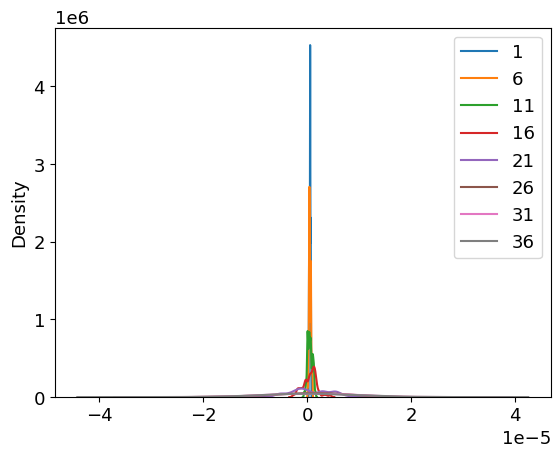

In [12]:
fig, ax = plt.subplots()

for t in range(1,40,5):
    sns.kdeplot(qhiresfcglayer1[t], ax=ax, label=str(t))
ax.legend()

<AxesSubplot:ylabel='Density'>

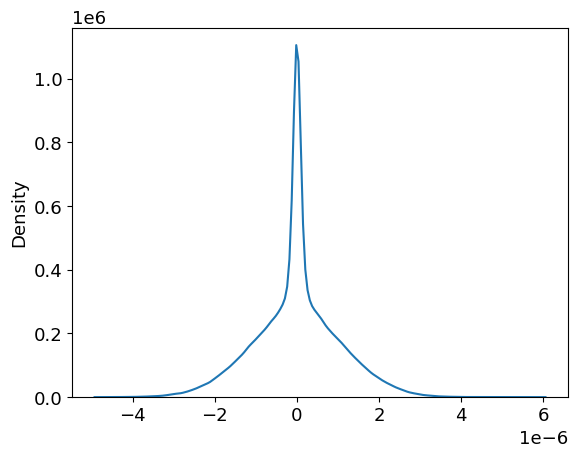

In [13]:
# benchmarking: combined over last 10000 units of time

fig, ax = plt.subplots()
sns.kdeplot(q1, ax=ax)
#for t in range(1,40,5):
#    sns.kdeplot(q1[t], ax=ax, label=str(t))
#ax.legend()

#>2 components

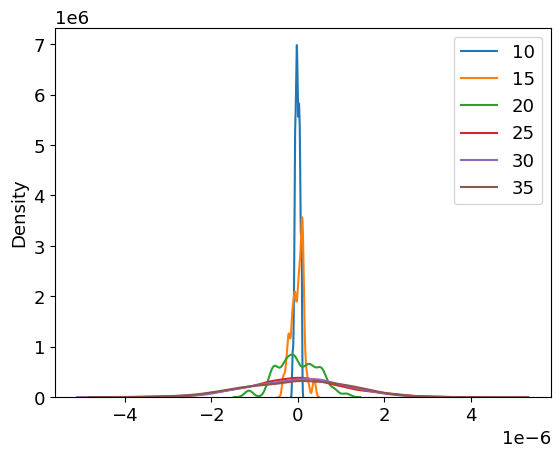

In [14]:
# benchmarking: separated by time steps
fig, ax = plt.subplots()

for t in range(10,40,5):
    for z in [0,1]:
    # Flatten over space 
        q1 = FeatureExtractor(eddy_forcing1.isel(lev=z,time=t))('q').ravel()
    sns.kdeplot(q1, ax=ax, label=str(t))
ax.legend()

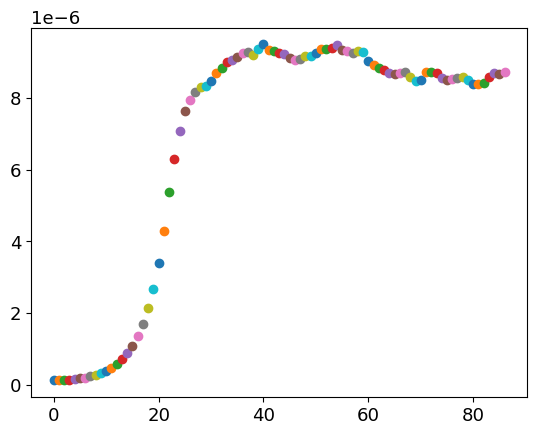

In [15]:
for t in range(0,87):
    plt.scatter(t, np.std(qhiresfcglayer1[t]))

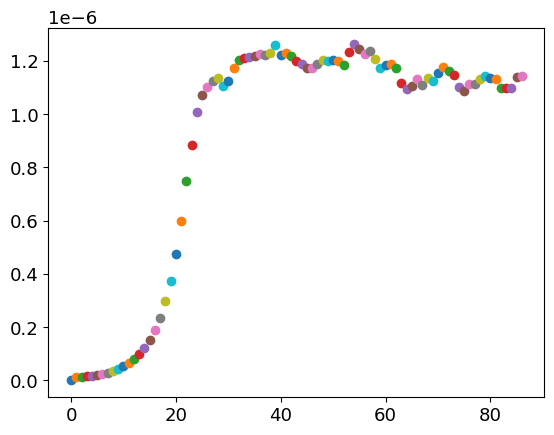

In [16]:
for t in range(0,87):
    for z in [0,1]:
    # Flatten over space 
        q1 = FeatureExtractor(eddy_forcing1.isel(lev=z,time=t))('q').ravel()
    plt.scatter(t, np.std(q1), label=str(t))
ax.legend()

In [18]:
#print(qhiresfcglayer1) # scale: order -7 to -5

[[ 5.3489447e-07  7.0972982e-07  8.2338943e-07 ...  7.2041570e-07
   7.7278207e-07  5.5097343e-07]
 [ 7.1675788e-07  5.9237260e-07  5.9396314e-07 ...  4.2797444e-07
   5.1040240e-07  7.8867629e-07]
 [ 5.2100137e-07  4.5055862e-07  5.6512505e-07 ...  5.7195564e-07
   8.1696714e-07  7.4617833e-07]
 ...
 [ 1.2093091e-05  3.9464976e-06 -4.6821183e-06 ... -2.8691243e-06
  -7.8115909e-07  1.0817998e-05]
 [-7.8005861e-08 -1.0065730e-05 -1.3967145e-05 ... -1.8151039e-06
   6.6683879e-06  1.5590718e-05]
 [ 6.9981015e-06  1.4792023e-06 -3.6956026e-06 ...  1.0737685e-05
   1.2185895e-05  1.2447055e-05]]


In [19]:
#print(tarhiresfcglayer1) # scale: order -17 to -11

[[-2.6468700e-16  2.8534846e-16  7.9648202e-17 ... -2.1278145e-16
   3.2306514e-16  2.1396730e-16]
 [-4.9526355e-16 -3.0262793e-16  4.0835120e-16 ... -9.8635293e-17
  -1.3276056e-16  4.4566130e-16]
 [ 5.0296139e-16 -1.4734816e-16 -3.2268567e-16 ...  1.7103289e-16
  -5.1843160e-16 -2.1984910e-16]
 ...
 [-3.6712369e-12  1.0665232e-12 -5.2316419e-13 ...  7.3824427e-12
   4.0423038e-12 -5.8967458e-12]
 [ 6.5146447e-12 -2.9402973e-12 -2.1239711e-12 ... -1.8216730e-12
  -2.7164597e-12 -2.8947717e-12]
 [ 5.7573768e-12 -5.6155193e-12  2.3671481e-12 ...  1.6568011e-11
   8.5590736e-13 -7.3118057e-12]]


---
## 2. WDL <a class="anchor" id="2"></a>
- Note: conducted on the data processed in part 1

In [20]:
%run WDL.ipynb

X = qhiresfcglayer1
# X2 = qhiresfcglayer2
Y = tarhiresfcglayer1
# Y2 = tarhiresfcglayer2

n_dist = Y.shape[0]
n_levs = 100
q_vec = torch.arange(1, n_levs, dtype=torch.float64) / n_levs # quantile levels

# transform Y
Q_mat = np.array([np.quantile(Y[i], q_vec) for i in range(n_dist)]) # calculate the empirical quantile function

K_mix = 2
n_iter = 1000
#lr = 1e-1
#v_lr = np.array([1] + [lr] * n_iter)

In [18]:
# train-test split

n_train = int(0.8 * n_dist)
loc_train = np.random.choice(n_dist, n_train, replace=False)
loc_val = np.setdiff1d(np.arange(n_dist), loc_train)


X_train = torch.tensor(X[loc_train])
# generate true parameters
mu_true = torch.cat((X_train[:, 0].unsqueeze(dim=1), (2 * X_train[:, 1] ** 2 + 2).unsqueeze(dim=1)), dim=1)
sd_true = torch.cat(
    (torch.abs(X_train[:, 1]).unsqueeze(dim=1) + 0.5, torch.abs(X_train[:, 0]).unsqueeze(dim=1) + 0.5), dim=1)
alpha_true = torch.cat((torch.zeros_like(X_train[:, 2].unsqueeze(dim=1)), X_train[:, 2].unsqueeze(dim=1)), dim=1)
pi_true = torch.softmax(alpha_true, dim=1)

# generate features
X_train = torch.cat((X_train, torch.abs(X_train), X_train ** 2), 1)
y_train = torch.tensor(Q_mat[loc_train])
X_val = torch.tensor(X[loc_val])
X_val = torch.cat((X_val, torch.abs(X_val), X_val ** 2), 1)
y_val = torch.tensor(Q_mat[loc_val])

In [19]:
# 1. train

alpha_matrix = torch.tensor(np.random.randn(len(X_train[0]), 2), requires_grad=True) # scale this down 10^-6
mu_matrix = torch.tensor(np.random.randn(len(X_train[0]), 2), requires_grad=True)
sd_matrix = torch.tensor(np.random.randn(len(X_train[0]), 2), requires_grad=True)

optimizer = torch.optim.SGD([alpha_matrix, mu_matrix, sd_matrix], lr=0.6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=170, gamma=0.84)

# train the model
for k in range(1000):
    alpha = torch.matmul(X_train, alpha_matrix.float())
    mu = torch.matmul(X_train, mu_matrix.float())
    sd = torch.abs(torch.matmul(torch.abs(X_train), sd_matrix.float()))

    pi = torch.softmax(alpha, dim=1)

    optimizer.zero_grad()
    loss = WDL(y_train, q_vec, mu, sd, pi)
    # print(k, loss.item()) # note: we want a decreasing sequence
    loss.backward()
    optimizer.step()
    scheduler.step()

0 1.0724685483468722e-06
1 1.0724683616716692e-06
2 1.072468144305619e-06
3 1.072467912949382e-06
4 1.0724677314129328e-06
5 1.072467543564466e-06
6 1.0724673471004595e-06
7 1.0724671314170403e-06
8 1.0724669404393147e-06
9 1.072466742874999e-06
10 1.072466536967991e-06
11 1.0724663228469806e-06
12 1.0724661240427858e-06
13 1.072465936171262e-06
14 1.0724657276640505e-06
15 1.0724655319557519e-06
16 1.072465316026275e-06
17 1.0724651331485627e-06
18 1.07246489709199e-06
19 1.0724647076036409e-06
20 1.0724644903630045e-06
21 1.0724643142973126e-06
22 1.0724640895380516e-06
23 1.0724638913880028e-06
24 1.0724636855406147e-06
25 1.0724634971188243e-06
26 1.0724632411970407e-06
27 1.0724630601200658e-06
28 1.072462857943301e-06
29 1.0724626879248754e-06
30 1.0724624899941337e-06
31 1.0724622923802713e-06
32 1.0724621038722556e-06
33 1.0724618996182342e-06
34 1.0724616827978348e-06
35 1.0724614678148575e-06
36 1.0724612907895258e-06
37 1.0724610672892018e-06
38 1.0724608961303486e-06
39 1.0

322 1.0724083380714638e-06
323 1.0724081668017187e-06
324 1.0724079904803556e-06
325 1.0724078288539188e-06
326 1.0724076708041366e-06
327 1.0724075374330498e-06
328 1.0724073248580272e-06
329 1.072407143981691e-06
330 1.0724070153909218e-06
331 1.0724068646579369e-06
332 1.0724066824749701e-06
333 1.072406495011e-06
334 1.07240629452192e-06
335 1.0724061356797008e-06
336 1.0724059783615399e-06
337 1.0724058021485261e-06
338 1.0724056100832298e-06
339 1.0724054716503563e-06
340 1.0724052842089753e-06
341 1.0724051412533482e-06
342 1.0724049656071752e-06
343 1.0724048264657724e-06
344 1.0724046807626248e-06
345 1.072404548496537e-06
346 1.0724043909790533e-06
347 1.072404265332984e-06
348 1.072404140212753e-06
349 1.072403983845212e-06
350 1.0724038209134623e-06
351 1.072403665859355e-06
352 1.0724035398851256e-06
353 1.0724034073905466e-06
354 1.072403252183412e-06
355 1.0724031367524338e-06
356 1.0724029654869086e-06
357 1.0724028251662206e-06
358 1.0724026638797834e-06
359 1.07240250

634 1.0723661642662345e-06
635 1.0723660569913256e-06
636 1.072365942180439e-06
637 1.07236578840927e-06
638 1.0723656502868547e-06
639 1.072365526451929e-06
640 1.0723653982527988e-06
641 1.0723652902608277e-06
642 1.0723651365587409e-06
643 1.0723650397751449e-06
644 1.072364926037144e-06
645 1.0723647934436123e-06
646 1.0723646582892347e-06
647 1.0723645607769732e-06
648 1.0723644209812707e-06
649 1.0723643379949228e-06
650 1.0723642378983168e-06
651 1.0723641021908404e-06
652 1.0723639975959879e-06
653 1.072363889541324e-06
654 1.072363776106996e-06
655 1.0723636444492368e-06
656 1.0723635307903168e-06
657 1.072363391534451e-06
658 1.0723632645908417e-06
659 1.0723631169773739e-06
660 1.0723630036722679e-06
661 1.0723628953040891e-06
662 1.0723627643325677e-06
663 1.0723626354694553e-06
664 1.072362489641519e-06
665 1.0723623899975356e-06
666 1.0723622547746362e-06
667 1.0723621742410854e-06
668 1.0723620423879145e-06
669 1.0723619256028098e-06
670 1.0723617766592323e-06
671 1.0723

945 1.0723354837686264e-06
946 1.0723353908932785e-06
947 1.072335310179288e-06
948 1.0723352148650452e-06
949 1.0723351611787344e-06
950 1.0723350681622966e-06
951 1.0723349988668294e-06
952 1.0723349172657954e-06
953 1.0723348281389164e-06
954 1.0723347570516875e-06
955 1.0723346864996719e-06
956 1.0723345709169582e-06
957 1.0723345046652937e-06
958 1.0723344005226468e-06
959 1.0723343201425924e-06
960 1.0723342335693182e-06
961 1.072334163729904e-06
962 1.072334077267696e-06
963 1.0723339910679478e-06
964 1.0723339185696901e-06
965 1.0723338423625564e-06
966 1.072333746178015e-06
967 1.0723336310714282e-06
968 1.072333558994087e-06
969 1.0723334783291659e-06
970 1.0723334070923753e-06
971 1.0723333188774745e-06
972 1.0723332391102893e-06
973 1.072333128488981e-06
974 1.0723330371046126e-06
975 1.0723329578956775e-06
976 1.0723328866328176e-06
977 1.0723328179203536e-06
978 1.0723327392872737e-06
979 1.0723326415122256e-06
980 1.072332541145092e-06
981 1.0723324582787851e-06
982 1.07

---
## 3. NN <a class="anchor" id="3"></a>

In [25]:
# 2. initialize FCNN 
in_q = ['q','u','v']
tar_q_tot = ['q_forcing_total']

#fcnn_q_qtot = FullyCNN(inputs=in_q, targets=tar_q_tot)
#fcnn_q_qtot.save('./models/fcnn_q_qtot')

In [27]:
fcnn_param = FCNNParameterization('./models/fcnn_q_qtot')

In [28]:
eddy_forcing1 = get_dataset('eddy/forcing1').isel(run=0).load()
eddy_forcing1['q_forcing_total'] = eddy_forcing1.dqdt_bar - eddy_forcing1.dqbar_dt

In [29]:
fcnn_param = fcnn_param.train_on(dataset = eddy_forcing1, inputs=in_q, targets=tar_q_tot, directory = './models/fcnn_q_qtot')

>###### 3.0 Get testing data <a class="anchor" id="3.0"></a>
>- see forcing_data.ipynb

In [44]:
%run forcing_data.ipynb

In [45]:
testing_data = generate_forcing_data()

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 1.48e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 2000, Time: 7.20e+06, KE: 1.59e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 3000, Time: 1.08e+07, KE: 1.98e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 4000, Time: 1.44e+07, KE: 2.60e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 5000, Time: 1.80e+07, KE: 3.58e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 6000, Time: 2.16e+07, KE: 5.15e-07, CFL: 0.023
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 7000, Time: 2.52e+07, KE: 7.68e-07, CFL: 0.023
INFO:  Logger i

INFO:  Logger initialized
INFO: Step: 60000, Time: 2.16e+08, KE: 6.54e-04, CFL: 0.250
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 61000, Time: 2.20e+08, KE: 6.77e-04, CFL: 0.235
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 62000, Time: 2.23e+08, KE: 6.36e-04, CFL: 0.234
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 63000, Time: 2.27e+08, KE: 6.34e-04, CFL: 0.237
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 64000, Time: 2.30e+08, KE: 6.50e-04, CFL: 0.230
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 65000, Time: 2.34e+08, KE: 6.28e-04, CFL: 0.211
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: Step: 66000, Time: 2.38e+08, KE: 6.16e-04, CFL: 0.228
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO: St

In [51]:
testing_data[0]['q_forcing_total'] = testing_data[0].dqdt_bar - testing_data[0].dqbar_dt

>###### 3.1 Test <a class="anchor" id="3.1"></a>
>1. eddy_forcing1 (benchmarking data)
>2. testing_data (generated via own code)

In [143]:
preds_q_qtot = fcnn_param.test_offline(eddy_forcing1)

In [144]:
print(preds_q_qtot)

<xarray.Dataset>
Dimensions:                               (time: 87, lev: 2, y: 64, x: 64)
Coordinates:
  * lev                                   (lev) int32 1 2
  * time                                  (time) float32 0.0 ... 3.096e+08
  * x                                     (x) float32 7.812e+03 ... 9.922e+05
  * y                                     (y) float32 7.812e+03 ... 9.922e+05
Data variables: (12/14)
    q_forcing_total                       (time, lev, y, x) float32 -2.647e-1...
    q_forcing_total_predictions           (time, lev, y, x) float32 6.706e-13...
    q_forcing_total_spatial_mse           (lev, y, x) float32 1.794e-23 ... 5...
    q_forcing_total_temporal_mse          (time, lev) float32 4.249e-27 ... 3...
    q_forcing_total_mse                   (lev) float32 1.677e-23 2.428e-27
    q_forcing_total_spatial_skill         (lev, y, x) float32 0.4142 ... 0.5236
    ...                                    ...
    q_forcing_total_spatial_correlation   (lev, y, x) f

In [145]:
# plot helpers 

def imshow(arr):
    plt.imshow(arr, vmin=0, vmax=1, cmap='inferno')
    mean = arr.mean().data
    plt.text(32, 32, f"{mean:.2f}", color=('white' if mean<0.75 else 'black'),
             fontweight='bold', ha='center', va='center', fontsize=16)
    plt.xticks([]); plt.yticks([])
    
def colorbar(label):
    plt.colorbar().set_label(label, fontsize=16,rotation=0,ha='left',va='center')

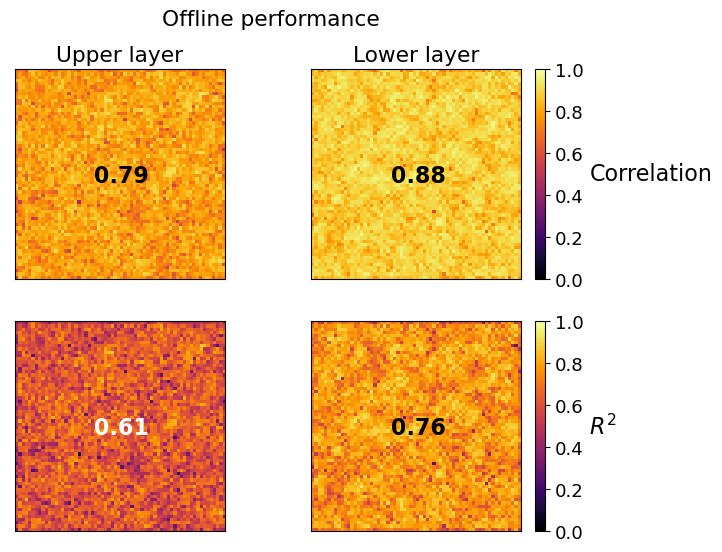

In [146]:
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds_q_qtot.q_forcing_total_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds_q_qtot.q_forcing_total_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

In [82]:
with open('./models/fcnn_q_qtot/models/0/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open('./models/fcnn_q_qtot/models/0/targets.pkl', 'rb') as f:
    targets = pickle.load(f)

print(inputs)
print(targets)

[('q', 0), ('q', 1), ('u', 0), ('u', 1), ('v', 0), ('v', 1)]
[('q_forcing_total', 0)]


---
## 4. WDL <a class="anchor" id="4"></a>

In [90]:
%run nnClassWOnly.ipynb

In [91]:
fcnn_param_wonly = FCNNParameterization_w('./models/fcnn_q_qtot_wonly')

In [ ]:
fcnn_param_wonly = fcnn_param_wonly.train_on(dataset = eddy_forcing1, inputs=in_q, targets=tar_q_tot, directory = './models/fcnn_q_qtot_wonly')

Loss after Epoch 1: 1.050383086085017
Loss after Epoch 2: 0.7299744174673808
Loss after Epoch 3: 0.5468794609281002
Loss after Epoch 4: 0.5373498523448932
Loss after Epoch 5: 0.5603101690371398
Loss after Epoch 6: 0.017959143892670993
Loss after Epoch 7: 0.6521918829777256
Loss after Epoch 8: 0.1631996725056774
Loss after Epoch 9: 0.22611939752079488
Loss after Epoch 10: 0.022551622562046687
Loss after Epoch 11: 0.19070675029440162
Loss after Epoch 12: 1.011522259457103
Loss after Epoch 13: 0.2846827854592394
Loss after Epoch 14: 0.49718011565926645
Loss after Epoch 15: 0.10542492186725322
Loss after Epoch 16: 0.5705176019954865
Loss after Epoch 17: 0.004731307086871859
Loss after Epoch 18: 0.49836364188587834
Loss after Epoch 19: 0.8010525680285863
Loss after Epoch 20: 0.31968656847470855


In [ ]:
preds_q_qtot_wonly = fcnn_param_wonly.test_offline(eddy_forcing1) # this should return (near) 100 accuracy since it's trained on this dataset...

In [ ]:
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds_q_qtot_wonly.q_forcing_total_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds_q_qtot_wonly.q_forcing_total_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

---
## 5. WDL + NN <a class="anchor" id="5"></a>

In [ ]:
%run nnClassW.ipynb

In [ ]:
fcnn_param_w = FCNNParameterization_w('./models/fcnn_q_qtot_w')

In [ ]:
fcnn_param_w = fcnn_param_w.train_on(dataset = eddy_forcing1, inputs=in_q, targets=tar_q_tot, directory = './models/fcnn_q_qtot_w')

In [ ]:
preds_q_qtot_w = fcnn_param_w.test_offline(eddy_forcing1) # this should return (near) 100 accuracy since it's trained on this dataset...

In [ ]:
plt.figure(figsize=(7.6,6)).suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds_q_qtot_w.q_forcing_total_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds_q_qtot_w.q_forcing_total_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

---
## 6. PCA/CCA on input/output <a class="anchor" id="6"></a>

In [55]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn import preprocessing

###### PCA on input:

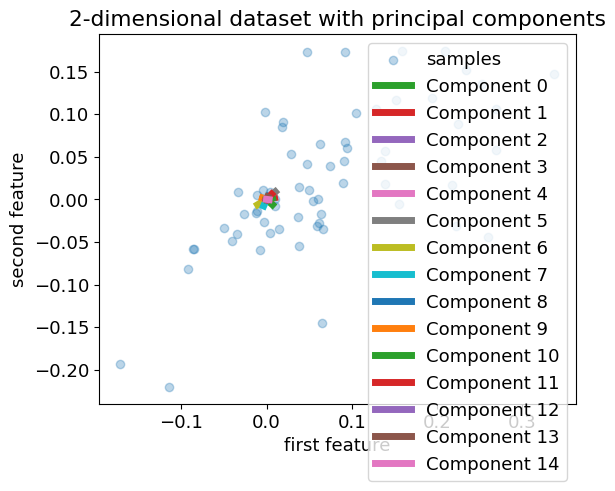

In [61]:
t_pca = 50
q_pca = preprocessing.normalize(eddy_forcing1['q'][t_pca][0])
pca = PCA(n_components=15).fit(q_pca)

plt.scatter(q_pca[:, 0], q_pca[:, 1], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot(
        [0, comp[0]],
        [0, comp[1]],
        label=f"Component {i}",
        linewidth=5,
        color=f"C{i + 2}",
    )
plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel="first feature",
    ylabel="second feature",
)
plt.legend()
plt.show()

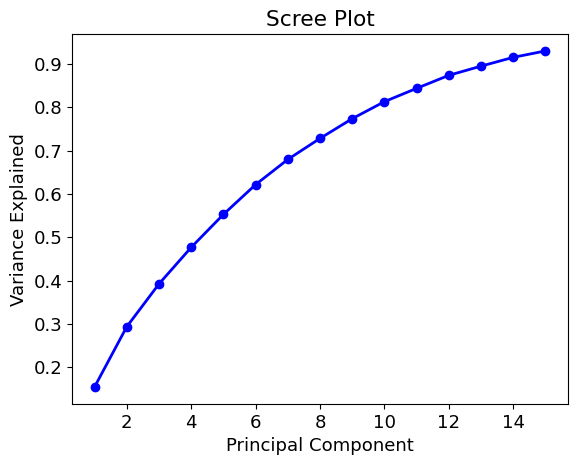

In [62]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# plot cumsum -- let total var -> 98-99

###### PCA on target:

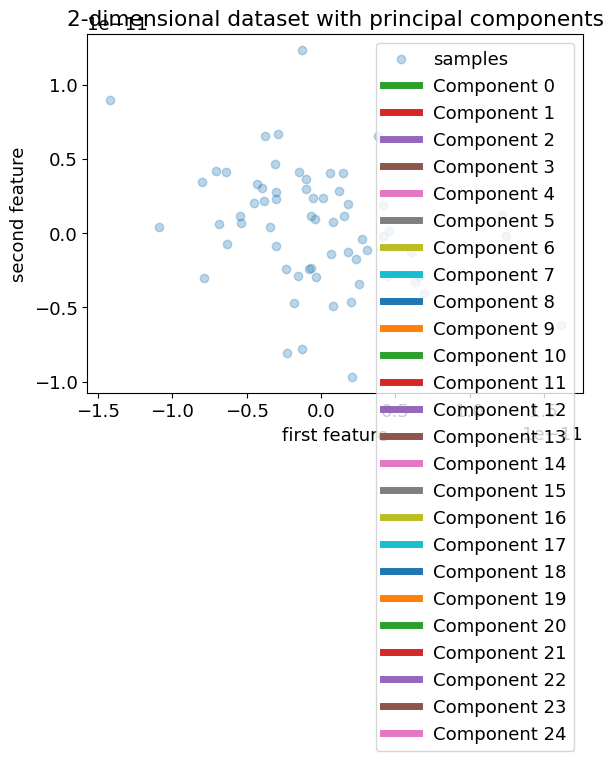

In [72]:
qtar_pca = preprocessing.normalize(eddy_forcing1['q_forcing_total'][t_pca][0])
pcatar = PCA(n_components=25).fit(qtar_pca)

plt.scatter(qtar_pca[:, 0], qtar_pca[:, 1], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pcatar.components_, pcatar.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot(
        [0, comp[0]],
        [0, comp[1]],
        label=f"Component {i}",
        linewidth=5,
        color=f"C{i + 2}",
    )
plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel="first feature",
    ylabel="second feature",
)
plt.legend()
plt.show()

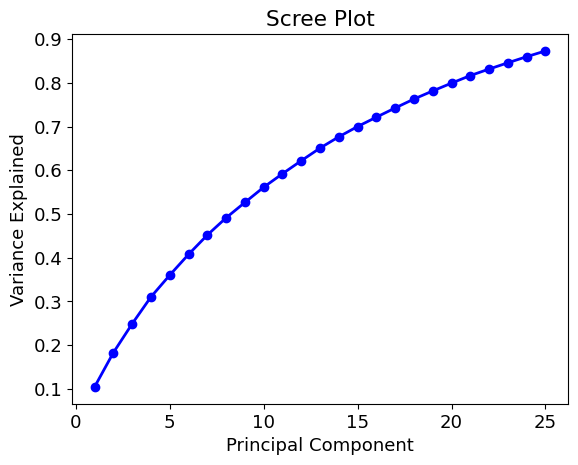

In [73]:
PCtar_values = np.arange(pcatar.n_components_) + 1
plt.plot(PCtar_values, pcatar.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

###### CCA:

In [74]:
# print errors
q_cca = preprocessing.normalize(eddy_forcing1['q'][t_pca][0])
cca = CCA(n_components=6).fit(q_cca,qtar_pca)